## Imports

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
print(sys.path[-1]) 


import rasterio
import numpy as np
from Ortomosaicos import read_tif_array, show_orthomosaic
#from Normalizacion import (
#    get_reference_profile,
#    align_all_campaigns,
#    normalize_all
#)

d:\Programas Python\Trabajo Final\Trabajo-Final\src


## EDA

### Carga de ortomosaicos

In [2]:
BASE_DIR = rf"D:\Programas Python\Trabajo Final\Trabajo-Final\data\Material\Ortomosaicos"

# 10 DE ENERO
MS_10ENE_RUTA = os.path.join(BASE_DIR, "10ene", "estanzuela_10ene_MS_orthophoto.tif")
RGB_10ENE_RUTA = os.path.join(BASE_DIR, "10ene", "estanzuela_10ene_rgb_orthophoto.tif")

# 17 DE ENERO
MS_17ENE_RUTA = os.path.join(BASE_DIR, "17ene", "estanzuela_17ene_MS_orthophoto.tif")
RGB_17ENE_RUTA = os.path.join(BASE_DIR, "17ene", "estanzuela_17ene_rgb_orthophoto.tif")

# 24 DE ENERO
MS_24ENE_RUTA = os.path.join(BASE_DIR, "24ene", "estanzuela_24ene_MS_orthophoto.tif")
RGB_24ENE_RUTA = os.path.join(BASE_DIR, "24ene", "estanzuela_24ene_rgb_orthophoto.tif")


# Carga de MS (Referencia y Datos)
MS_10ENE_DATA, MS_10ENE_PERFIL = read_tif_array(MS_10ENE_RUTA)
MS_17ENE_DATA, MS_17ENE_PERFIL = read_tif_array(MS_17ENE_RUTA)
MS_24ENE_DATA, MS_24ENE_PERFIL = read_tif_array(MS_24ENE_RUTA)

# Carga de RGB (Datos)
RGB_10ENE_DATA, _ = read_tif_array(RGB_10ENE_RUTA)
RGB_17ENE_DATA, _ = read_tif_array(RGB_17ENE_RUTA)
RGB_24ENE_DATA, _ = read_tif_array(RGB_24ENE_RUTA)

#### Asignación de ortomosaico actual

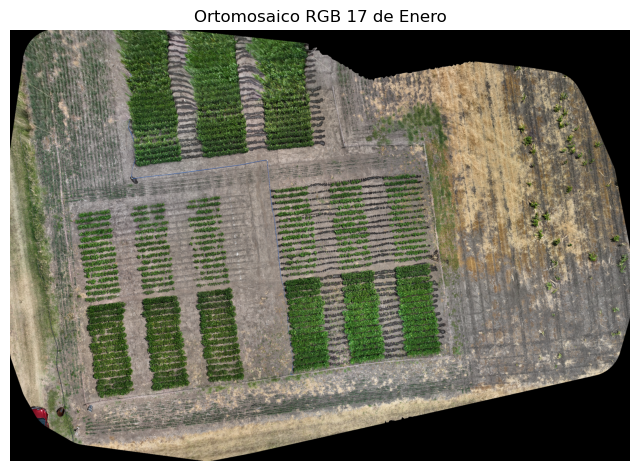

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2085809..1.0].


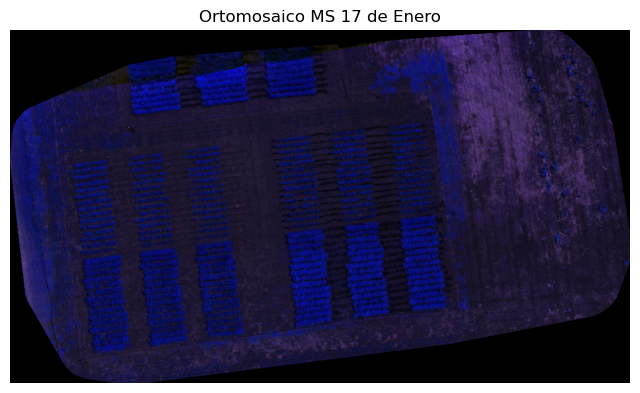

In [3]:
ortomosaico_rgb = RGB_17ENE_DATA
ortomosaico_ms = MS_17ENE_DATA
show_orthomosaic(ortomosaico_rgb, title="Ortomosaico RGB 17 de Enero")
show_orthomosaic(ortomosaico_ms, title="Ortomosaico MS 17 de Enero")

In [4]:
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
print(sys.path[-1]) 

import rasterio
import numpy as np
import matplotlib.pyplot as plt # Agregado por si acaso para plots rápidos
from Ortomosaicos import read_tif_array, show_orthomosaic

# Definimos aquí la función de alineación para no depender de archivos externos por ahora
def alinear_rgb_con_ms(ruta_rgb, perfil_referencia):
    """
    Abre la imagen RGB y la reproyecta al espacio del perfil de referencia (MS).
    Incluye corrección de artefactos de interpolación (clipping).
    """
    with rasterio.open(ruta_rgb) as src:
        # 1. Crear matriz vacía con la forma exacta de la Referencia
        datos_reproyectados = np.zeros(
            (src.count, perfil_referencia['height'], perfil_referencia['width']), 
            dtype=np.float32 # Usamos float para precisión en índices
        )
        
        # 2. Reproyectar (Alineación Espacial)
        reproject(
            source=rasterio.band(src, list(range(1, src.count + 1))),
            destination=datos_reproyectados,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=perfil_referencia['transform'],
            dst_crs=perfil_referencia['crs'],
            resampling=Resampling.bilinear
        )
        
        # 3. CORRECCIÓN DE COLORES (Clipping)
        # Eliminamos el "undershoot" (valores negativos) y "overshoot" (mayores a 1 o 255)
        # Asumimos que si es float, el rango es 0-1. Si es int, 0-255.
        
        if datos_reproyectados.max() <= 1.5: 
            # Caso probable: Imagen normalizada 0.0 - 1.0
            datos_reproyectados = np.clip(datos_reproyectados, 0.0, 1.0)
        else:
            # Caso probable: Imagen en 8 bits (0-255) o 16 bits
            max_val = 255 if datos_reproyectados.max() <= 255 else 65535
            datos_reproyectados = np.clip(datos_reproyectados, 0, max_val)

    return datos_reproyectados

d:\Programas Python\Trabajo Final\Trabajo-Final\src


In [5]:
# %%
BASE_DIR = rf"D:\Programas Python\Trabajo Final\Trabajo-Final\data\Material\Ortomosaicos"

# --- DEFINICIÓN DE RUTAS ---

# 10 DE ENERO
MS_10ENE_RUTA = os.path.join(BASE_DIR, "10ene", "estanzuela_10ene_MS_orthophoto.tif")
RGB_10ENE_RUTA = os.path.join(BASE_DIR, "10ene", "estanzuela_10ene_rgb_orthophoto.tif")

# 17 DE ENERO
MS_17ENE_RUTA = os.path.join(BASE_DIR, "17ene", "estanzuela_17ene_MS_orthophoto.tif")
RGB_17ENE_RUTA = os.path.join(BASE_DIR, "17ene", "estanzuela_17ene_rgb_orthophoto.tif")

# 24 DE ENERO
MS_24ENE_RUTA = os.path.join(BASE_DIR, "24ene", "estanzuela_24ene_MS_orthophoto.tif")
RGB_24ENE_RUTA = os.path.join(BASE_DIR, "24ene", "estanzuela_24ene_rgb_orthophoto.tif")


# --- CARGA DE DATOS ---

print("--- Cargando Multispectrales (Referencia) ---")
# Cargamos MS normalmente. Guardamos el PERFIL porque es nuestra "Regla Maestra" de dimensiones.
MS_10ENE_DATA, MS_10ENE_PERFIL = read_tif_array(MS_10ENE_RUTA)
MS_17ENE_DATA, MS_17ENE_PERFIL = read_tif_array(MS_17ENE_RUTA)
MS_24ENE_DATA, MS_24ENE_PERFIL = read_tif_array(MS_24ENE_RUTA)
print(f"Dimensiones MS 17ene: {MS_17ENE_DATA.shape}")


print("\n--- Cargando y Alineando RGBs al MS ---")
# En lugar de usar read_tif_array directo, usamos nuestra función de alineación.
# Le pasamos la ruta del RGB y el PERFIL del MS correspondiente como molde.

RGB_10ENE_DATA = alinear_rgb_con_ms(RGB_10ENE_RUTA, MS_10ENE_PERFIL)
RGB_17ENE_DATA = alinear_rgb_con_ms(RGB_17ENE_RUTA, MS_17ENE_PERFIL)
RGB_24ENE_DATA = alinear_rgb_con_ms(RGB_24ENE_RUTA, MS_24ENE_PERFIL)

# Verificación visual rápida en consola
print(f"Dimensiones RGB 17ene (Alineado): {RGB_17ENE_DATA.shape}")

# Comprobación de seguridad: Si esto falla, el código se detiene.
assert MS_17ENE_DATA.shape[1:] == RGB_17ENE_DATA.shape[1:], "Error: Las dimensiones espaciales no coinciden."
print("¡Éxito! Las matrices RGB y MS ahora son gemelas en tamaño.")

--- Cargando Multispectrales (Referencia) ---
Dimensiones MS 17ene: (5, 621, 1090)

--- Cargando y Alineando RGBs al MS ---
Dimensiones RGB 17ene (Alineado): (4, 621, 1090)
¡Éxito! Las matrices RGB y MS ahora son gemelas en tamaño.


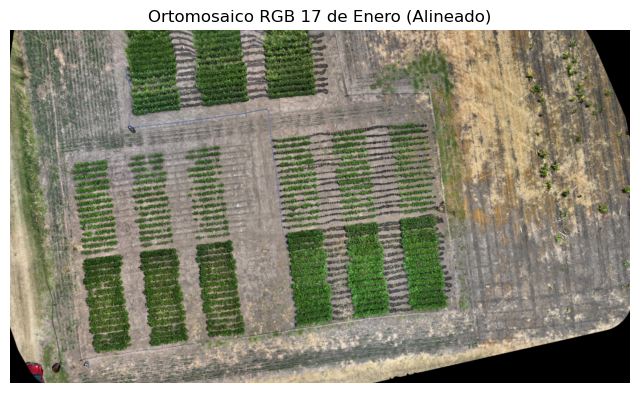

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2085809..1.0].


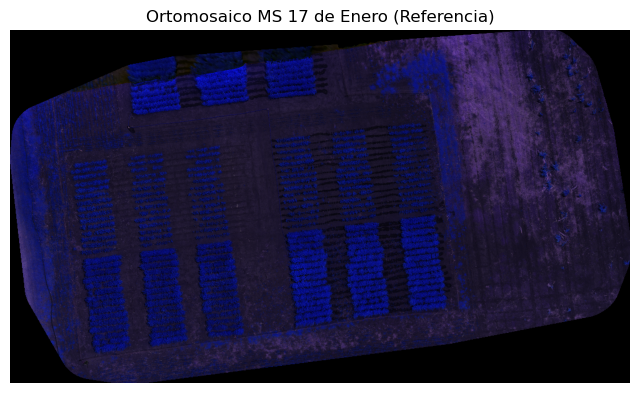

In [6]:
# %%
# #### Asignación de ortomosaico actual

# Elegimos la fecha con la que vamos a trabajar (enfoque intra-fecha)
ortomosaico_rgb = RGB_17ENE_DATA
ortomosaico_ms = MS_17ENE_DATA

# Visualizamos
# Nota: Si Ortomosaicos.show_orthomosaic espera (Bandas, Alto, Ancho), esto funcionará perfecto.
show_orthomosaic(ortomosaico_rgb, title="Ortomosaico RGB 17 de Enero (Alineado)")
show_orthomosaic(ortomosaico_ms, title="Ortomosaico MS 17 de Enero (Referencia)")

In [7]:
# %% [markdown]
# ### Exportación de Resultados para QGIS
# Guardamos las imágenes alineadas como GeoTIFF para inspección visual.

# %%
import os

# Definimos una carpeta de salida para no mezclar con los originales
OUTPUT_DIR = os.path.join(BASE_DIR, "..", "..", "results", "aligned_check")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def guardar_geotiff(ruta_salida, datos_imagen, perfil_referencia):
    """
    Guarda una matriz numpy como GeoTIFF usando los metadatos espaciales
    de un perfil de referencia, actualizando la cantidad de bandas.
    """
    # Copiamos el perfil para no modificar el original en memoria
    perfil_salida = perfil_referencia.copy()
    
    # ACTUALIZACIÓN CRÍTICA:
    # La imagen RGB alineada puede tener 3 o 4 bandas, mientras que la MS tiene 5.
    # Debemos decirle al archivo de salida cuántas bandas vamos a escribir.
    perfil_salida.update({
        'driver': 'GTiff',
        'count': datos_imagen.shape[0],  # Cantidad de bandas (ej. 4 para RGB)
        'dtype': datos_imagen.dtype,     # Tipo de dato (ej. float32 o uint8)
        'height': datos_imagen.shape[1], # Alto
        'width': datos_imagen.shape[2]   # Ancho
    })
    
    print(f"Guardando en: {ruta_salida}")
    with rasterio.open(ruta_salida, 'w', **perfil_salida) as dst:
        dst.write(datos_imagen)
    print("-> Guardado exitoso.")

# --- EJECUCIÓN ---

# 1. Definir nombre del archivo de salida
nombre_archivo = "DEV_rgb_17ene_alineado_al_ms.tif"
ruta_completa = os.path.join(OUTPUT_DIR, nombre_archivo)

# 2. Guardar el RGB alineado usando el perfil del MS (que es el "molde" espacial)
#guardar_geotiff(ruta_completa, RGB_17ENE_DATA, MS_17ENE_PERFIL)

# Opcional: Guardar también el MS recortado/procesado si hubieras hecho cambios, 
# pero como es el original, ya lo tienes en disco.

In [8]:
# %% [markdown]
# ## Segmentación de Cultivos (NDVI + Otsu)
# Calculamos el índice NDVI y generamos una máscara binaria (Planta vs Suelo).

# %%
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

# %%
# Definimos las rutas de las bandas espectrales individuales
# Según tu inventario, están en la misma carpeta del 17ene
NIR_17ENE_RUTA = os.path.join(BASE_DIR, "17ene", "estanzuela_17ene_NIR_orthophoto.tif")
RED_17ENE_RUTA = os.path.join(BASE_DIR, "17ene", "estanzuela_17ene_RED_orthophoto.tif")

# Cargamos y alineamos las bandas usando TU función existente.
# Esto garantiza que el NDVI tenga exactamente las mismas dimensiones que el RGB y el MS.
print("--- Alineando bandas espectrales (NIR y RED) ---")
nir_data = alinear_rgb_con_ms(NIR_17ENE_RUTA, MS_17ENE_PERFIL)
red_data = alinear_rgb_con_ms(RED_17ENE_RUTA, MS_17ENE_PERFIL)

# Como alinear devuelve (Bandas, Alto, Ancho) y estas son monocromáticas,
# nos quedamos con la primera banda (índice 0) para operar matrices 2D.
nir_band = nir_data[0]
red_band = red_data[0]

print(f"Bandas listas. Shape: {nir_band.shape}")

ImportError: DLL load failed while importing _nd_image: %1 no es una aplicación Win32 válida.

Umbral de Otsu calculado: 0.2617
Rango del NDVI: -1.00 a 1.00


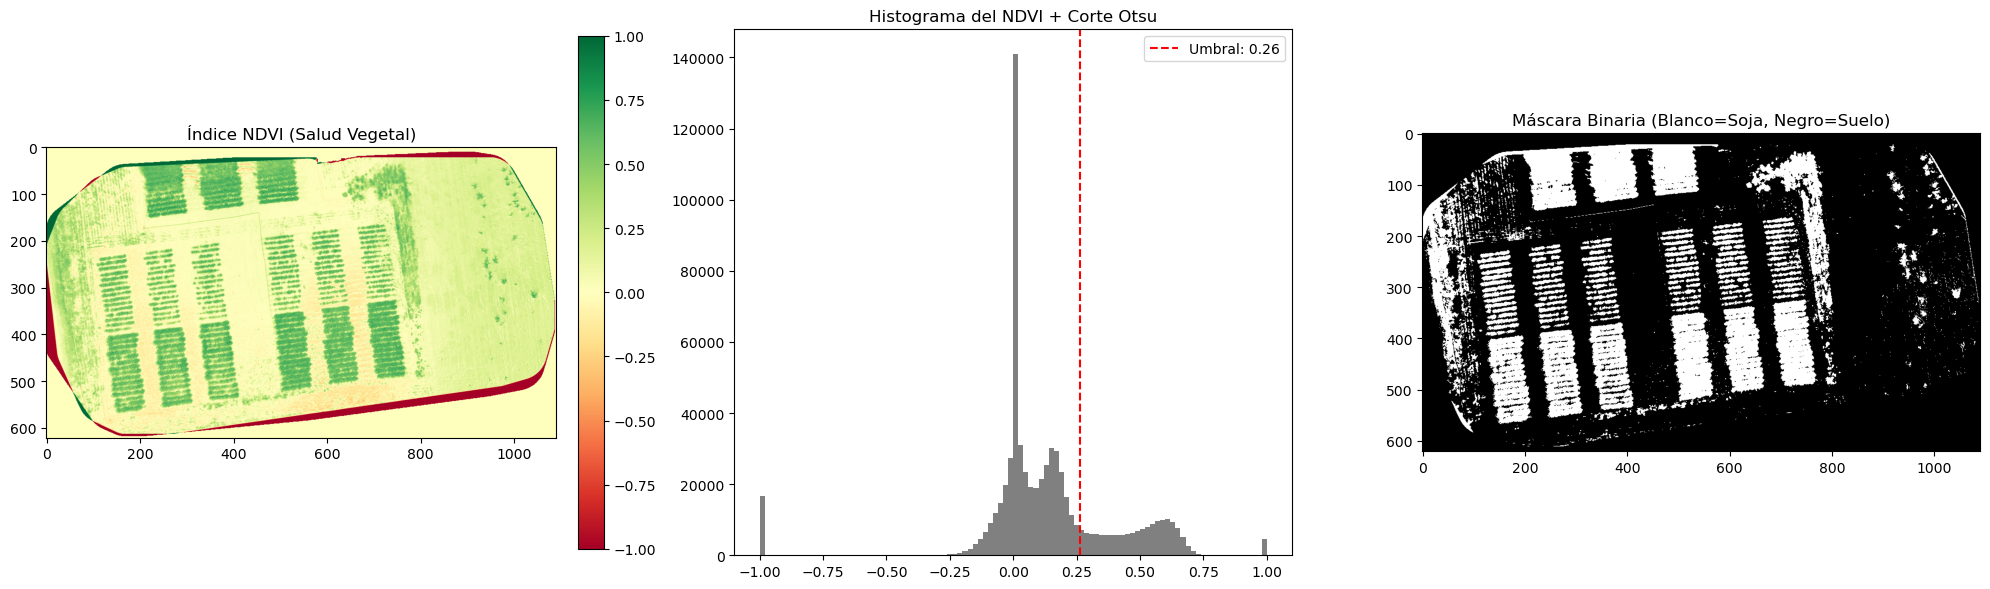

In [ ]:
# %%
# --- CÁLCULO DE NDVI ---
# Fórmula: (NIR - RED) / (NIR + RED)
# Sumamos un epsilon pequeño (1e-6) para evitar división por cero.
epsilon = 1e-6
ndvi = (nir_band - red_band) / (nir_band + red_band + epsilon)

# --- SEGMENTACIÓN AUTOMÁTICA (OTSU) ---
# Otsu encuentra el valor "mágico" que mejor separa dos grupos de histograma
umbral_otsu = threshold_otsu(ndvi)
mascara_cultivo = ndvi > umbral_otsu

print(f"Umbral de Otsu calculado: {umbral_otsu:.4f}")
print(f"Rango del NDVI: {ndvi.min():.2f} a {ndvi.max():.2f}")

# %%
# --- VISUALIZACIÓN ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Mapa de NDVI
im1 = axes[0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0].set_title("Índice NDVI (Salud Vegetal)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# 2. Histograma para ver el corte
axes[1].hist(ndvi.ravel(), bins=100, color='gray')
axes[1].axvline(umbral_otsu, color='r', linestyle='--', label=f'Umbral: {umbral_otsu:.2f}')
axes[1].set_title("Histograma del NDVI + Corte Otsu")
axes[1].legend()

# 3. Máscara Resultante (Segmentación)
axes[2].imshow(mascara_cultivo, cmap='gray')
axes[2].set_title("Máscara Binaria (Blanco=Soja, Negro=Suelo)")

plt.tight_layout()
plt.show()